## EOCIS data access over STAC - example

This example notebook demonstrates how to obtain EOCIS Sea-Surface Temperature 

In [1]:
import datetime
from pystac_client import Client
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import aiohttp
import time

In [2]:
# open the STAC endpoint provided by CEDA
client = Client.open("https://api.stac.ceda.ac.uk")

In [5]:
# search for SST data from 2023
search = client.search(
    collections=['eocis-sst-cdrv3'],
    datetime=(datetime.datetime(2023,1,1,12,0,0),datetime.datetime(2023,12,31,12,0,0))
)

In [6]:
# retrieve the items as dictionaries, rather than Item objects
items = list(search.items_as_dicts())
print (len(items)) # we should get 365 items, one for each day of 2023

365


In [7]:
# define a helper function that will get the access url from each stac item

def get_data_url(from_item):
    for (key,value) in from_item.assets.items():
        if key == "reference_file":
            return value.href
    return None

In [8]:
# define a helper function that will load an xarray dataset, given its url

def load_dataset(url):
    return xr.open_dataset("reference://", engine="zarr", backend_kwargs={
                 "consolidated": False,
                 "storage_options": {"fo": url, "remote_protocol": "https","remote_options": {}}
                 })
    return ds

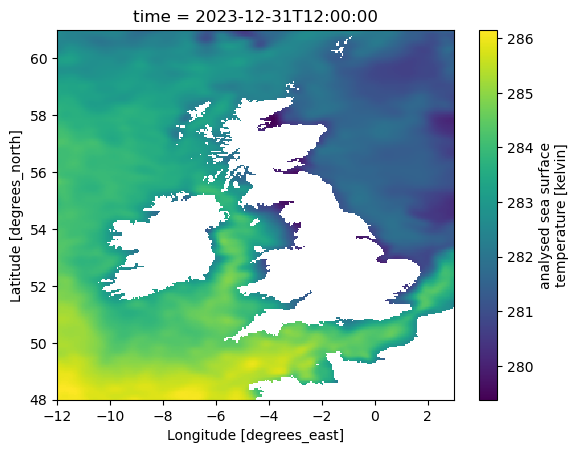

In [9]:
# plot the first item 
first_item = search.item_collection().items[0]
first_url = get_data_url(first_item)  # get the url for the item
ds = load_dataset(first_url)
ds["analysed_sst"].sel(lat=slice(48,61),lon=slice(-12,3)).plot()

In [10]:
# lets obtain the time series of mean sea surface temperatures for this area for 2023

# go through the items returned from the search, open the dataset 
# select the data we need covering the sea around the Bristish Isles and get the mean temperature on each day

# this will take a little time to run, but only the requested subset of the data will be downloaded from CEDA

data = [] # append the mean daily temperature to this list

for itemNo, item in enumerate(search.item_collection().items):
    url = get_data_url(item)
    attempts = 0
    try:
        ds = load_dataset(url)
        sst = ds["analysed_sst"].sel(lat=slice(48,61),lon=slice(-12,3)).mean(dim=['lat','lon']).load()
        data.append(sst)
    except Exception as e:
        # retrieval can hit occasional problems due to network errors, so use a limited number of retries
        attempts += 1
        if attempts >= 5:
            raise
        print ("Retrying:", attempts)
        time.sleep(5)

da = xr.concat(data,dim="time")

print(da)

Retrying: 1
<xarray.DataArray 'analysed_sst' (time: 364)> Size: 3kB
array([283.04910457, 283.11001034, 283.14907001, 283.19777793,
       283.23826667, 283.2553193 , 283.21340045, 283.23088226,
       283.20400916, 283.24439321, 283.39155382, 283.44478645,
       283.42287385, 283.28176338, 283.20575022, 283.30504011,
       283.38080916, 283.51706834, 283.56683083, 283.58905403,
       283.60968063, 283.63482482, 283.66823645, 283.70450396,
       283.74999401, 283.78201946, 283.82267071, 283.91396279,
       283.99195244, 284.03446593, 284.06057754, 284.128088  ,
       284.19967992, 284.2213998 , 284.29200104, 284.27120135,
       284.28121975, 284.3300558 , 284.39810119, 284.53070444,
       284.55510485, 284.58747962, 284.61783936, 284.68879913,
       284.73500935, 284.8017722 , 284.82263353, 284.84819267,
       284.88087684, 284.95594012, 284.98542794, 285.007506  ,
       285.11578751, 285.21240226, 285.24588716, 285.27928074,
       285.35957572, 285.41638857, 285.47973805, 2

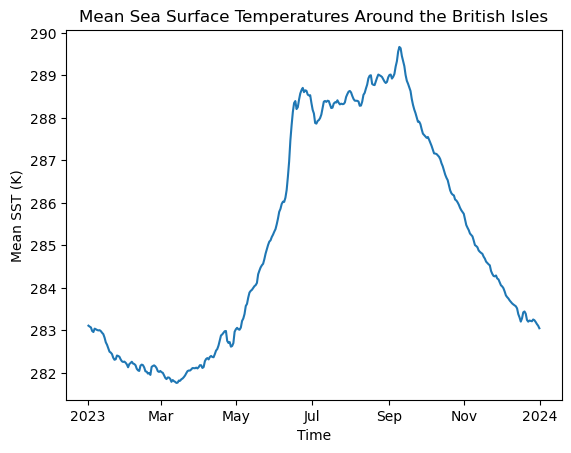

In [11]:
# take the mean along the time dimension, and plot the time series

da = da.sortby('time', ascending=True)

da.plot()
plt.title('Mean Sea Surface Temperatures Around the British Isles')
plt.ylabel('Mean SST (K)')
plt.xlabel('Time')
plt.show()